# Motivation

Statistically prove that drought has occured in year 2018 for xanten area by showing reduction preciptition for year 2018 with comparision of year 2016 and 2017


# Steps to be followed for analysis

 1) Read DWD CDC Time Series precpitition data<br />
 2) Merge with Station Description of Xanten <br />
 3) Filtering data of interested time range <br />
 4) precpitition analysis over Time range <br />
 5) Save data from time series analysis <br />


## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
# topic_dir = "/hourly/precipitation/recent/"
topic_dir = "/daily/more_precip/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/more_precip/historical/
data/original/DWD//daily/more_precip/historical/

data/generated/DWD/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

In [8]:
#ftp.quit()

### FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head()

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_more_pre...,.pdf,72261,-
1,-1,DESCRIPTION_obsgermany_climate_daily_more_prec...,.pdf,71026,-
2,-1,RR_Tageswerte_Beschreibung_Stationen.txt,.txt,1202111,-
3,1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
4,2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-


### Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head()

,name,ext,size,type
station_id,,,,
1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-


### Download the Station Description File

In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Tageswerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1912-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
2,1951-01-01,2006-12-31,138,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
4,1951-01-01,1979-10-31,243,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen
6,1982-11-01,2020-03-01,455,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg


### Select Stations Located in NRW from Station Description Dataframe

In [18]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    2,     3,     4,    38,    42,    79,    98,   104,   110,
              186,
            ...
            15456, 15559, 15919, 15927, 15963, 15980, 16087, 19042, 19043,
            19125],
           dtype='int64', name='station_id', length=500)

In [19]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

# df_stations.get_value()

xanten= df_stations['name'] == "Xanten"


dfNRW = df_stations[xanten]
lat=dfNRW['latitude']
lat_all=df_stations['latitude']

isLatCovered = (df_stations['latitude'] == dfNRW.iloc[0]['latitude'])&(df_stations['latitude'] == dfNRW.iloc[0]['latitude'])

isLongCovered = (df_stations['longitude'] == dfNRW.iloc[0]['longitude'])&(df_stations['longitude'] == dfNRW.iloc[0]['longitude'])

dateFilter=(df_stations['date_from']<='2016')&(df_stations['date_to']>='2018')
# df_stations['latitude'] > dfNRW.iloc[0]['latitude']
    #latValue=df_stations['latitude']
# isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isLatCovered&isLongCovered&dateFilter] 
#print("Number of stations in NRW: \n", dfNRW.count())

dfNRW


,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
5733,1951-01-01,2020-03-01,20,51.697,6.3974,Xanten,Nordrhein-Westfalen


In [20]:
print(df_zips.head())

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  109677    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   82951    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  162410    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   45468    -
6           tageswerte_RR_00006_19821101_20181231_hist.zip  .zip   38084    -


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [21]:
list(dfNRW.index)

[5733]

In [22]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_RR_05733_19510101_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [23]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from zipfile import ZipFile

In [25]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                if not dftmp.empty:
                    s = dftmp["rs"].rename(dftmp["stations_id"][0]).to_frame()
                    # outer merge.
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#     df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [26]:
df_merged_ts = temp_ts_merge()

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_05733_19510101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20181231_05733.txt



In [27]:
if df_merged_ts.index.dtype != "int64":
  try:
      df_merged_ts.reset_index(level=0, inplace=True)
  except:
      df_merged_ts.reset_index(drop=True)

In [28]:
df_merged_ts.columns = ['time','precipt']
df_merged_ts.head()

,time,precipt
0,1951-01-01,0.0
1,1951-01-02,0.0
2,1951-01-03,0.0
3,1951-01-04,7.5
4,1951-01-05,0.0


In [29]:
df_merged_ts.head()

,time,precipt
0,1951-01-01,0.0
1,1951-01-02,0.0
2,1951-01-03,0.0
3,1951-01-04,7.5
4,1951-01-05,0.0


The days selected are 
(a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11

In [30]:
date_a = pd.Timestamp(2016,5,8)
date_c = pd.Timestamp(2017,5,26)
date_e = pd.Timestamp(2018,5,11)


In [31]:
def subtract_years(d, years_to_subtract):
  return d - pd.DateOffset(years = 1)

In [32]:
df_date_a = df_merged_ts[(df_merged_ts['time']<=date_a) & (df_merged_ts['time'] > subtract_years(date_a,1))]
df_date_c = df_merged_ts[(df_merged_ts['time']<=date_c) & (df_merged_ts['time'] > subtract_years(date_c,1))]
df_date_e = df_merged_ts[(df_merged_ts['time']<=date_e) & (df_merged_ts['time'] > subtract_years(date_e,1))]

Calculate cumulative precipitation

In [33]:
df_date_a.head()

,time,precipt
22653,2015-05-09,0.7
22654,2015-05-10,0.0
22655,2015-05-11,0.0
22656,2015-05-12,0.0
22657,2015-05-13,0.0


In [34]:
df_date_a['cumPrecipt']= df_date_a['precipt'].cumsum()
df_date_c['cumPrecipt']= df_date_c['precipt'].cumsum()
df_date_e['cumPrecipt']= df_date_e['precipt'].cumsum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Plot cumlulative precpitiation for range of year

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

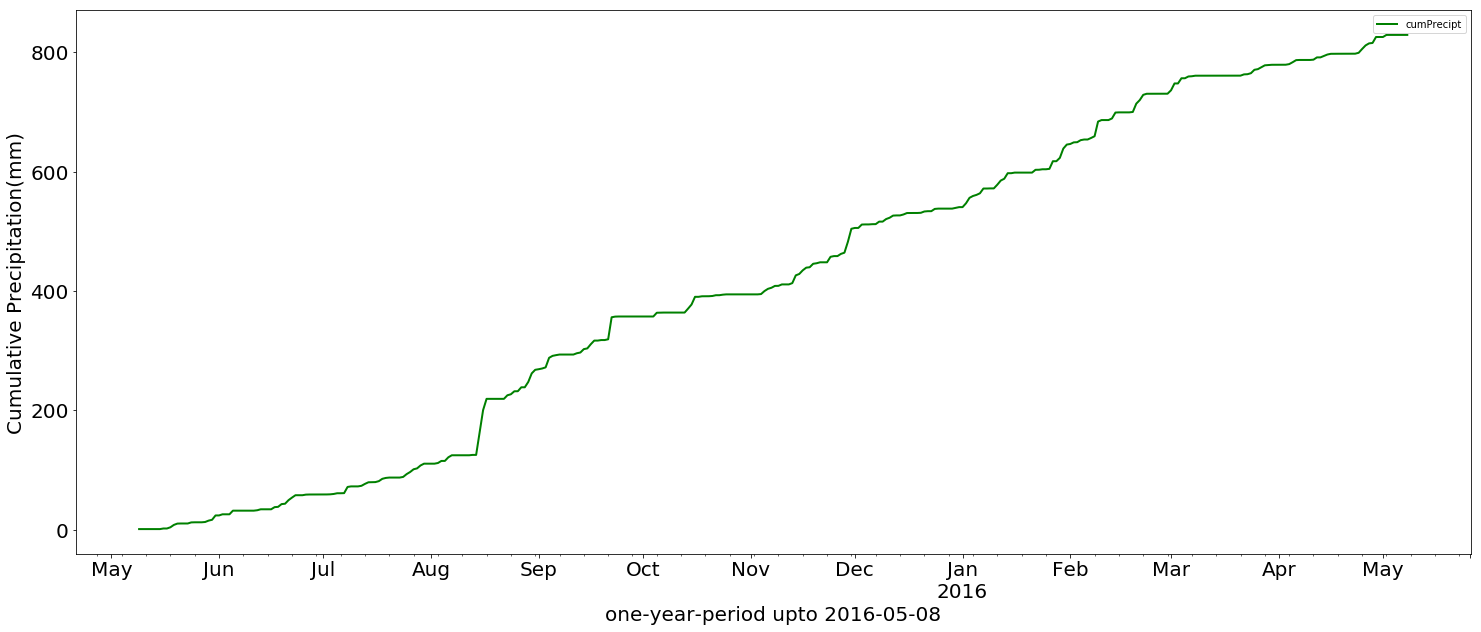

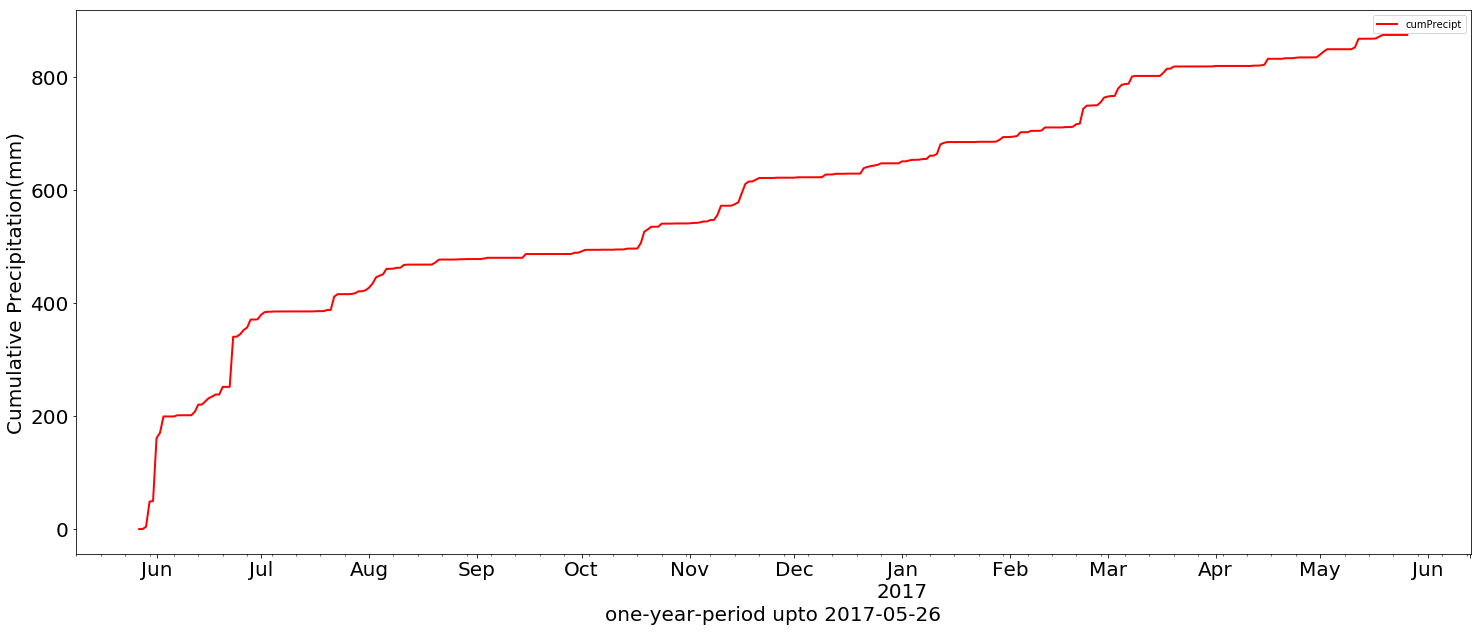

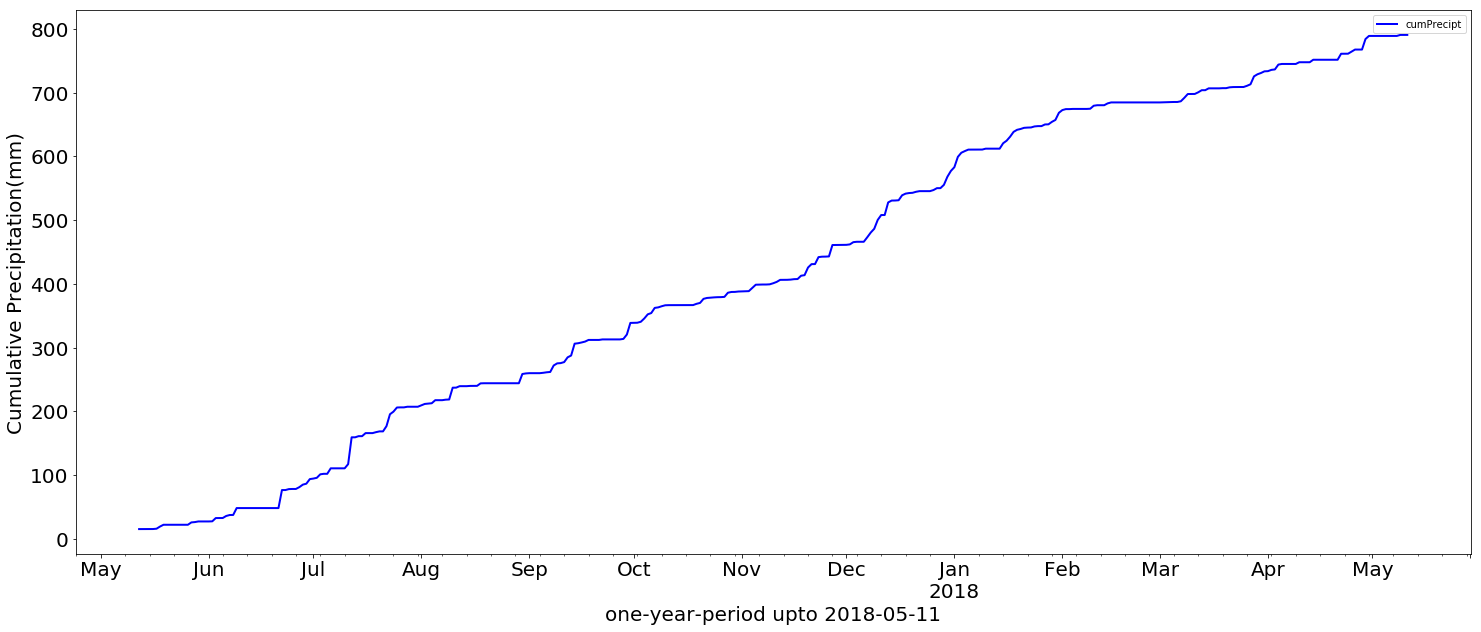

In [36]:
#The days selected are (a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11
# line plot for avg tempertaure vs time form 2015-05-09 to 2016-05-08
df_date_a.plot(kind='line',x='time',y='cumPrecipt',color='green', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2016-05-08', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)



# line plot for avg tempertaure vs time form 2016-05-27 to 2017-05-26
df_date_c.plot(kind='line',x='time',y='cumPrecipt',color='red', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2017-05-26', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)



# line plot for avg tempertaure vs time form 2018-05-12 to 2018-05-11
df_date_e.plot(kind='line',x='time',y='cumPrecipt',color='blue', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2018-05-11', fontsize=20)
plt.ylabel('Cumulative Precipitation(mm)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)


### **Find cumulative precpitation for 3 years**



The cumulative precpitation are:
[829.4000000000002, 874.0000000000003, 790.9]


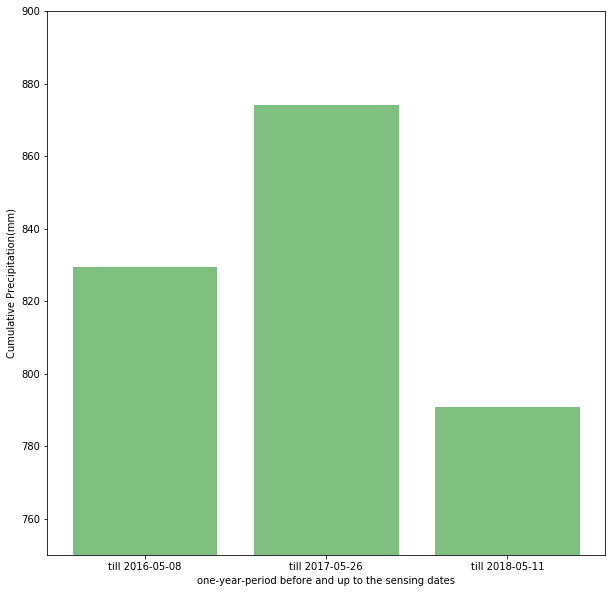

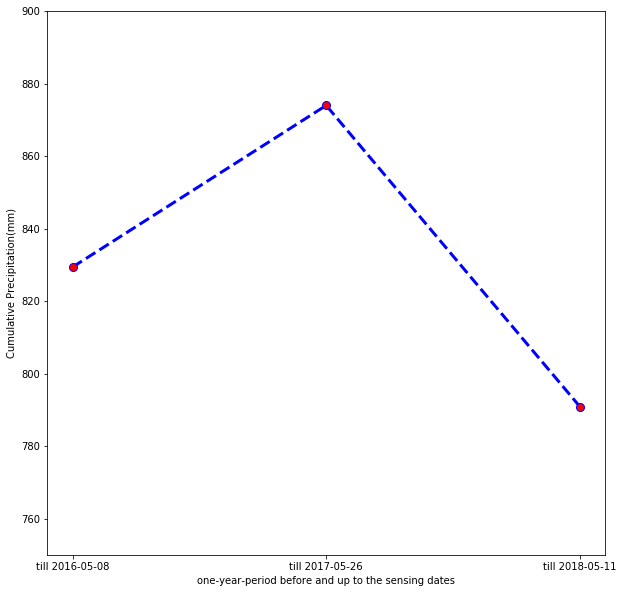

In [37]:
#The days selected are (a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11
#Displaying cumulative precpitation values for month of May and June in the year 2016, 2017, 2018 for 3 dataframe

sensing_date = ['till 2016-05-08', 'till 2017-05-26', 'till 2018-05-11']
cumPrecipt = [df_date_a['cumPrecipt'].iloc[-1], df_date_c['cumPrecipt'].iloc[-1], df_date_e['cumPrecipt'].iloc[-1]]
print('The cumulative precpitation are:')
print(cumPrecipt)

#Bar plot
plt.figure(figsize=(10,10))
plt.bar(sensing_date, cumPrecipt, color='green', align='center', alpha=0.5) 
axes = plt.gca()
axes.set_ylim([750,900])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Cumulative Precipitation(mm)')
plt.show()

#Line graph
plt.figure(figsize=(10,10))
plt.plot(sensing_date, cumPrecipt, color='blue',linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)
axes = plt.gca()
axes.set_ylim([750,900])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Cumulative Precipitation(mm)')
plt.show()

## save data

In [38]:
df_all_date = df_date_a.append(df_date_c)
df_all_date = df_all_date.append(df_date_e)
# df_all_date.to_csv('cumulated_precipitation.csv',index = True)
# from google.colab import files
# files.download('cumulated_precipitation.csv')
df_all_date.shape

(1096, 3)

In [39]:
df_all_precpit = df_all_date[['time','precipt']]
df_all_precpit.drop_duplicates(keep='first',inplace=True)
df_all_precpit.shape
df_all_precpit.to_csv('cumulated_precipitation.csv',index = True)
# from google.colab import files
# files.download('cumulated_precipitation.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
df_date_a['precipt'].sum()

829.4000000000001

In [41]:
df_stations = pd.DataFrame()
df_stations['time'] = df_all_precpit['time']
df_stations['latitude'] = dfNRW.loc[5733]['latitude']
df_stations['longitude'] = dfNRW.loc[5733]['longitude']
df_stations['precipt'] = df_all_precpit['precipt']
df_stations.head()

,time,latitude,longitude,precipt
22653,2015-05-09,51.697,6.3974,0.7
22654,2015-05-10,51.697,6.3974,0.0
22655,2015-05-11,51.697,6.3974,0.0
22656,2015-05-12,51.697,6.3974,0.0
22657,2015-05-13,51.697,6.3974,0.0


In [42]:
df_stations.to_csv('timeseries_preciptation.csv',index= True)
# from google.colab import files
# files.download('heatmap_preciptation.csv')